In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files from Zenodo

In [2]:
url_hall = "https://zenodo.org/record/1162952/files/Hall.csv"
url_wahono = "https://zenodo.org/record/1162952/files/Wahono.csv"
url_radjenovic = "https://zenodo.org/record/1162952/files/Radjenovic.csv"
zip_kitchenham = ZipFile(BytesIO(urlopen("https://zenodo.org/record/1162952/files/Kitchenham.zip").read()), "r")

In [3]:
df_hall = pd.read_csv(url_hall, usecols=lambda column: column not in ["PDF Link"])
df_wahono = pd.read_csv(url_wahono, usecols=lambda column: column not in ["PDF Link"])
df_radjenovic = pd.read_csv(url_radjenovic, usecols=lambda column: column not in ["PDF Link"], encoding="iso-8859-1")
df_kitchenham = pd.read_csv(zip_kitchenham.open("Kitchenham/Kitchenham.csv"), 
                            usecols=lambda column: column not in ["PDF Link", "Source", "abs"], encoding="iso-8859-1")

## Clean datasets

In [4]:
def std_inclusion(df):
    
    # add record_id
    df.insert(0, "record_id", df.index + 1)
    
    # label inclusion indicator
    df["label"] = np.where(df["label"] == "yes", 1, 0)
    df.rename(columns={"label": "label_included"}, inplace=True)
    
    # standardize column names
    df.rename(columns={"Document Title": "title"}, inplace=True)
    df.columns = map(str.lower, df.columns)
    
    # find duplicates based on title and authors
    df = df.assign(title_clean=df["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower())
    df.sort_values(["label_included"], ascending=False, inplace=True)
    duplicate = df.duplicated(subset=["title_clean"]) & ~df.title_clean.isnull()
    df["duplicate_record_id"] = np.where(duplicate, 1, np.nan)
    
    # if duplicate, duplicate_id indicates the corresponding record_id, otherwise NA
    for i in range(len(df)):
        if df.loc[i, "duplicate_record_id"] == 1:
            df.loc[i, "duplicate_record_id"] = df.loc[~duplicate & df.loc[~duplicate, "title_clean"].isin([df.loc[i, "title_clean"]]), "record_id"].tolist()
    df.duplicate_record_id = df.duplicate_record_id.astype("Int64")
    
    # sort by orginal order
    df.sort_values("record_id", inplace=True)
    
    return df

In [5]:
df_hall = std_inclusion(df_hall)
df_wahono = std_inclusion(df_wahono)
df_radjenovic = std_inclusion(df_radjenovic)
df_kitchenham = std_inclusion(df_kitchenham)

## Export datasets

In [6]:
Path("output").mkdir(parents=True, exist_ok=True)
df_hall.to_csv("output/Hall_2012.csv", index=False)
df_wahono.to_csv("output/Wahono_2015.csv", index=False)
df_radjenovic.to_csv("output/Radjenovic_2013.csv", index=False)
df_kitchenham.to_csv("output/Kitchenham_2010.csv", index=False)

## Datasets statistics

In [7]:
df_hall.name = "Hall"
df_wahono.name = "Wahono"
df_radjenovic.name = "Radjenovic"
df_kitchenham.name = "Kitchenham"

In [8]:
def summary_stats(df):
    """Overview of number of papers and inclusion rate"""
    
    # summary of inclusions and exclusions
    n = len(df)
    n_dup = (~df["duplicate_record_id"].isna()).sum()
    n_wo_dup = n - n_dup
    n_inc = df.loc[df.duplicate_record_id.isna(), "label_included"].sum()
    n_exc = n_wo_dup - n_inc
    
    print("Total number of papers:                    ", n, "(includes", n_dup, "duplicates) \n")
    print("Total number of papers without duplicates: ", n_wo_dup, "\n\n")
    print("Following statistics calculated without duplicates: \n")
    print("Total number of EXCLUSIONS: ", n_exc, "\n")
    print("Total number of INCLUSIONS: ", n_inc, " (", round(100*n_inc/n_wo_dup, 2), "% )\n\n")

    # missingness of title and abstract
    print("Missingness of title and abstract: \n")
    print("Number of papers with missing title:    ", df["title"].isna().sum(), "\n")
    print("Number of papers with missing abstract: ", df["abstract"].isna().sum(), "\n")
    
    # plot number of papers over years
    df.groupby("year").size().reset_index(name="count").set_index("year").plot(figsize=(15,5))
    plt.title("Number of papers in "+ df.name + " dataset over years")
    plt.show()

In [9]:
# word cloud for titles and abstracts
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["based", "use", "used", "using", "approach", "method", "result", "conclusion"])

def word_cloud(df):
    """Word cloud for titles and abstracts"""
    
    # create word cloud text
    title_text = " ".join(str(word) for word in df.title)
    abstract_text = " ".join(str(word) for word in df.abstract)
    print("\n", "There are {} words in the combination of all titles in".format(len(title_text)), df.name, "dataset.")
    print("\n", "There are {} words in the combination of all abstracts in".format(len(abstract_text)), df.name, "dataset.", "\n")

    # generate word cloud images
    title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
    abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
    ax1.imshow(title_wordcloud, interpolation="bilinear")
    ax1.set_title("Titles of " + df.name + " dataset")
    ax1.axis("off")
    ax2.imshow(abstract_wordcloud, interpolation="bilinear")
    ax2.set_title("Abstracts of " + df.name + " dataset")
    ax2.axis("off")
    plt.show()

### Hall dataset

Total number of papers:                     8911 (includes 99 duplicates) 

Total number of papers without duplicates:  8812 


Following statistics calculated without duplicates: 

Total number of EXCLUSIONS:  8708 

Total number of INCLUSIONS:  104  ( 1.18 % )


Missingness of title and abstract: 

Number of papers with missing title:     0 

Number of papers with missing abstract:  0 



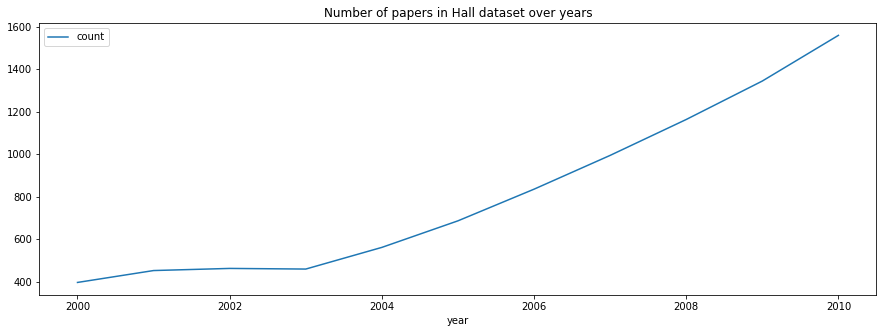


 There are 726474 words in the combination of all titles in Hall dataset.

 There are 7994398 words in the combination of all abstracts in Hall dataset. 



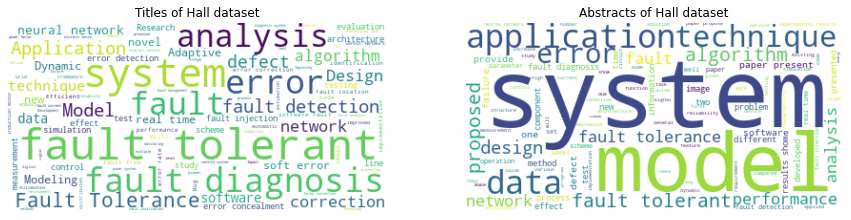

In [10]:
summary_stats(df_hall)
word_cloud(df_hall)

### Wahono dataset

Total number of papers:                     7002 (includes 37 duplicates) 

Total number of papers without duplicates:  6965 


Following statistics calculated without duplicates: 

Total number of EXCLUSIONS:  6903 

Total number of INCLUSIONS:  62  ( 0.89 % )


Missingness of title and abstract: 

Number of papers with missing title:     0 

Number of papers with missing abstract:  0 



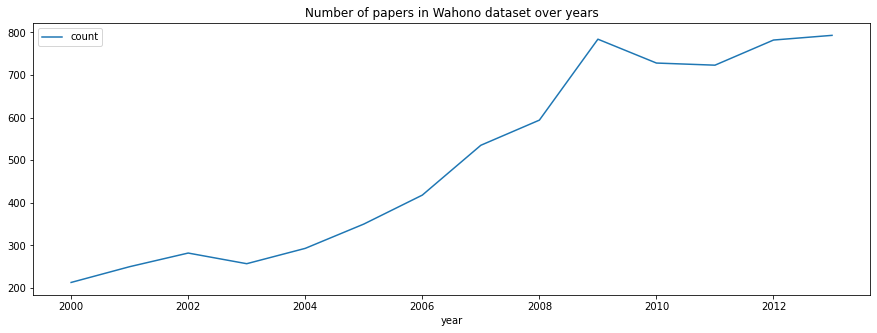


 There are 523154 words in the combination of all titles in Wahono dataset.

 There are 7400396 words in the combination of all abstracts in Wahono dataset. 



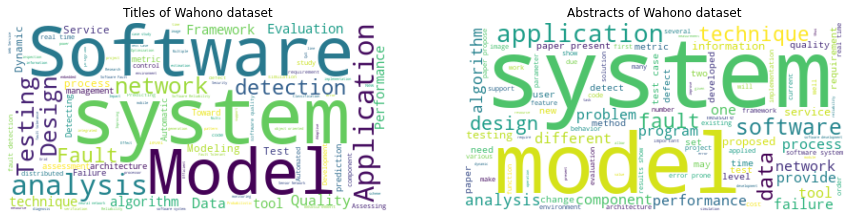

In [11]:
summary_stats(df_wahono)
word_cloud(df_wahono)

### Radjenovic dataset

Total number of papers:                     6000 (includes 51 duplicates) 

Total number of papers without duplicates:  5949 


Following statistics calculated without duplicates: 

Total number of EXCLUSIONS:  5901 

Total number of INCLUSIONS:  48  ( 0.81 % )


Missingness of title and abstract: 

Number of papers with missing title:     0 

Number of papers with missing abstract:  0 



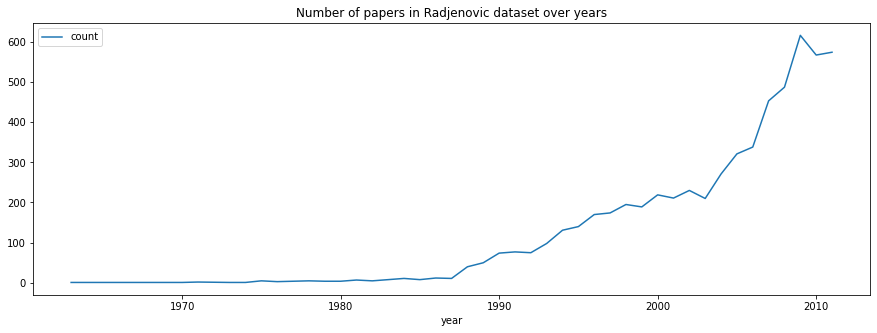


 There are 443437 words in the combination of all titles in Radjenovic dataset.

 There are 6052325 words in the combination of all abstracts in Radjenovic dataset. 



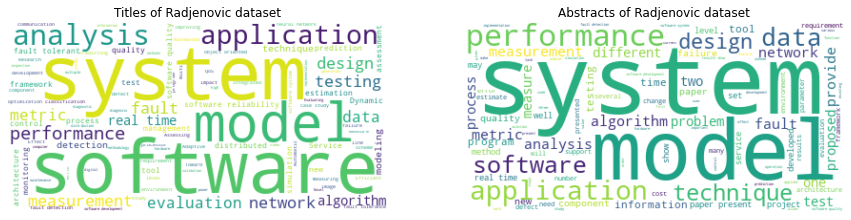

In [12]:
summary_stats(df_radjenovic)
word_cloud(df_radjenovic)

### Kitchenham dataset

Total number of papers:                     1704 (includes 6 duplicates) 

Total number of papers without duplicates:  1698 


Following statistics calculated without duplicates: 

Total number of EXCLUSIONS:  1653 

Total number of INCLUSIONS:  45  ( 2.65 % )


Missingness of title and abstract: 

Number of papers with missing title:     0 

Number of papers with missing abstract:  4 



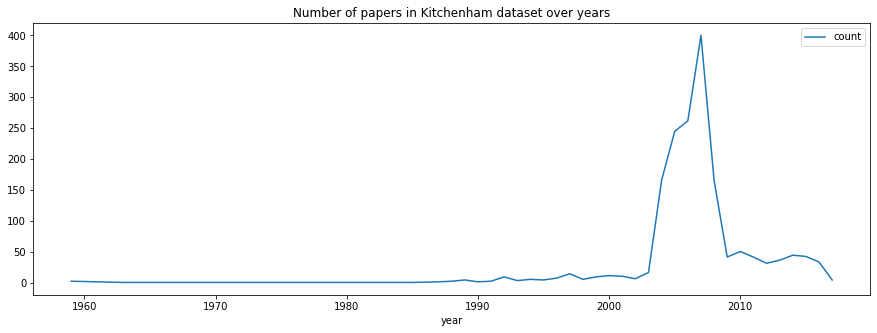


 There are 126247 words in the combination of all titles in Kitchenham dataset.

 There are 1668594 words in the combination of all abstracts in Kitchenham dataset. 



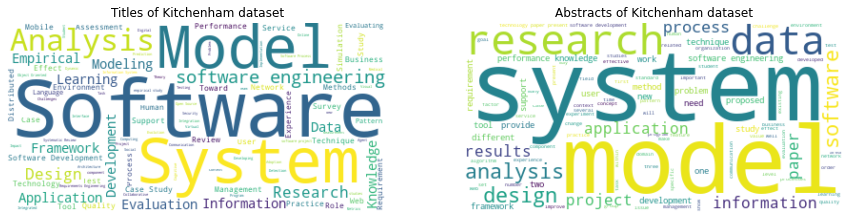

In [13]:
summary_stats(df_kitchenham)
word_cloud(df_kitchenham)